Using device: cuda


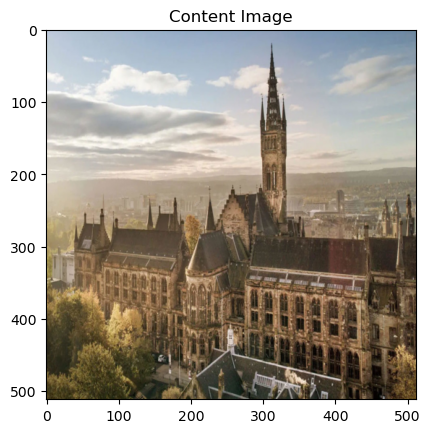

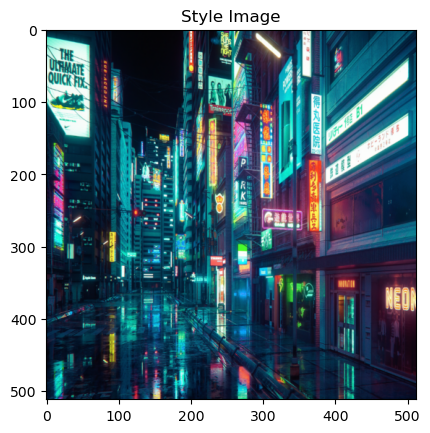

Step 0: total=20794939392.00, content=0.00, style=0.00


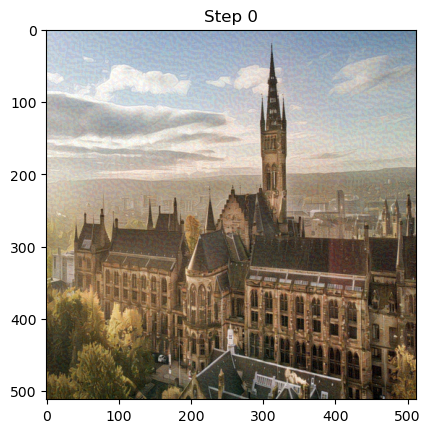

Step 100: total=196267616.00, content=3.17, style=0.00


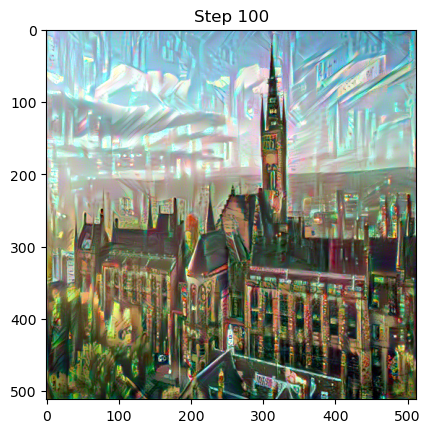

Step 200: total=115587712.00, content=3.21, style=0.00


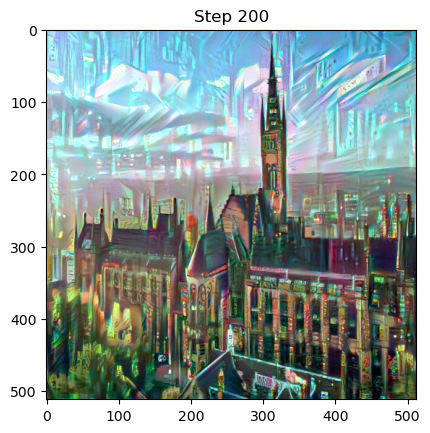

Step 300: total=80607608.00, content=3.30, style=0.00


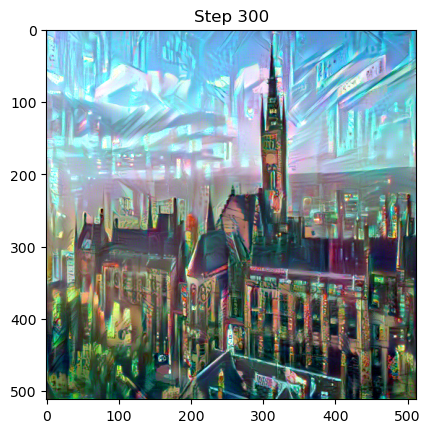

Step 400: total=121457360.00, content=3.26, style=0.00


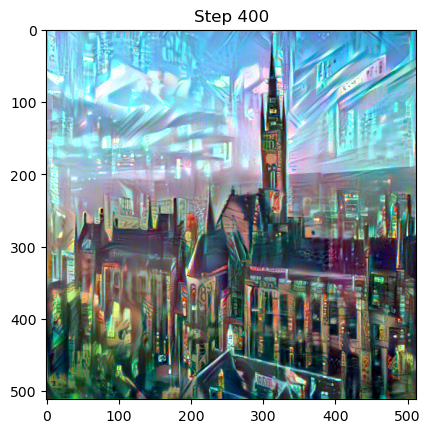

Step 500: total=66720852.00, content=3.33, style=0.00


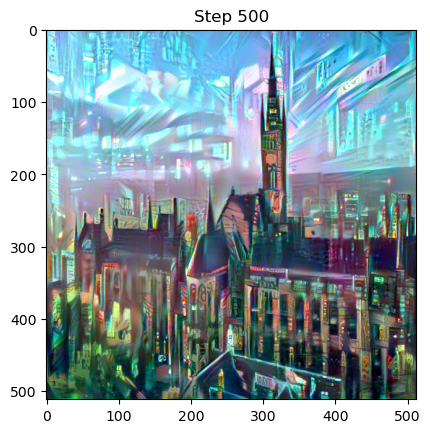

Step 600: total=51663020.00, content=3.38, style=0.00


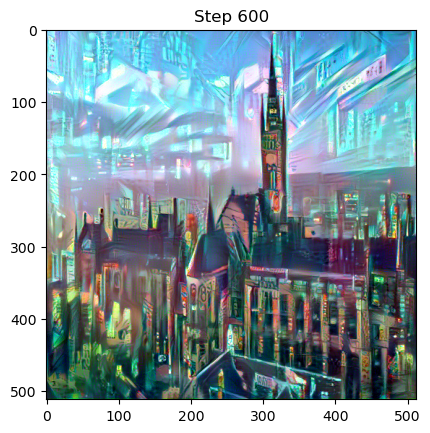

Step 700: total=482918048.00, content=3.19, style=0.00


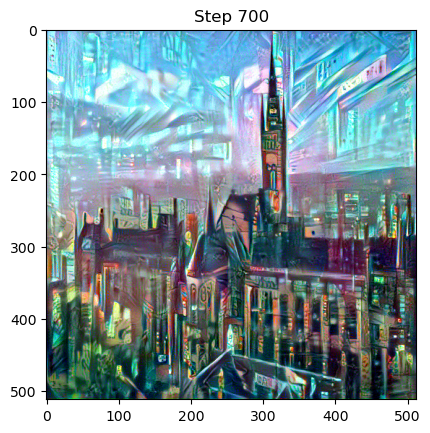

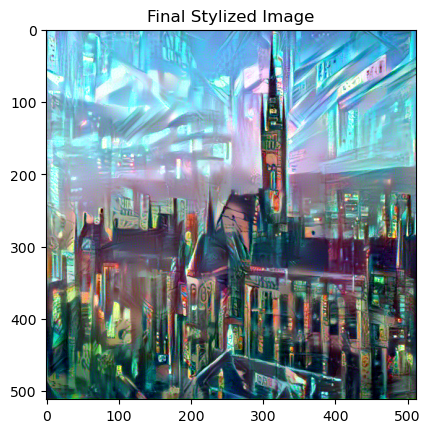

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# 1. cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

##############################################################################
# 2. load picture
##############################################################################
imsize = 512  
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  
    transforms.ToTensor()                
])

def image_loader(path):
    
    image = Image.open(path).convert('RGB')
    image = loader(image).unsqueeze(0)  
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    
    image = tensor.detach().cpu().clone().squeeze(0)  # shape: (3,H,W)
    image = torch.clamp(image, 0, 1)                  
    image = image.permute(1,2,0)                      # (C,H,W)->(H,W,C)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

def style_loader(path):
    image = Image.open(path).convert('RGB')
    # 让风格图更暗
    enhancer_b = ImageEnhance.Brightness(image)
    image = enhancer_b.enhance(0.4)  # 0.7 -> 更暗
    
    # 让对比度更强
    enhancer_c = ImageEnhance.Contrast(image)
    image = enhancer_c.enhance(1.8)  # 1.3 -> 更高对比
    
    # 之后再转tensor
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

content_img = image_loader(r"D:\Desktop\ai\figures\figures\content.jpg")
style_img = image_loader(r"D:\Desktop\ai\figures\figures\style.jpg")

plt.figure()
imshow(content_img, "Content Image")
plt.figure()
imshow(style_img, "Style Image")
plt.show()

##############################################################################
# 3.VGG-16 
##############################################################################
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features.to(device).eval()

# vgg.features 
#  0: Conv2d(3,64)
#  1: ReLU
#  2: Conv2d(64,64)
#  3: ReLU
#  4: MaxPool2d
#  5: Conv2d(64,128)
#  ...
# 17: Conv2d(256,512) -> conv4_1
# 18: ReLU
# 19: Conv2d(512,512) -> conv4_2
# 20: ReLU
# 21: Conv2d(512,512) -> conv4_3
# 22: ReLU
# 23: MaxPool2d
# 24: Conv2d(512,512) -> conv5_1
# ...
# 30: MaxPool2d

# content & style
content_layers = [19]

style_layers   = [0, 5, 10, 17, 24]

def get_features(x, model, content_layers, style_layers):
    
    content_feats = {}
    style_feats = {}
    for name, layer in enumerate(model):
        x = layer(x)
        if name in content_layers:
            content_feats[name] = x
        if name in style_layers:
            style_feats[name] = x
    return content_feats, style_feats

##############################################################################
# 4. extract
##############################################################################
with torch.no_grad():
    content_feats, _ = get_features(content_img, vgg, content_layers, style_layers)
    _, style_feats = get_features(style_img, vgg, content_layers, style_layers)

def gram_matrix(tensor):
    B, C, H, W = tensor.shape
    feats = tensor.view(B, C, H*W)
    G = torch.bmm(feats, feats.transpose(1,2))  # (B, C, C)
    return G / (C*H*W)

style_grams = {}
for layer, feat in style_feats.items():
    style_grams[layer] = gram_matrix(feat).detach()  

##############################################################################
# 5. optimize
##############################################################################
generated_img = content_img.clone().requires_grad_(True)  
optimizer = optim.Adam([generated_img], lr=0.03)  

##############################################################################
# 6.loss
##############################################################################
tv_weight = 1e-5

def total_variation_loss(img):
    diff_h = torch.mean(torch.abs(img[:,:,1:,:] - img[:,:,:-1,:]))
    diff_w = torch.mean(torch.abs(img[:,:,:,1:] - img[:,:,:,:-1]))
    return diff_h + diff_w

def total_loss_fn(gen_img, alpha=1.0, beta=1e6):
    gen_content_feats, gen_style_feats = get_features(gen_img, vgg, content_layers, style_layers)
    

    content_loss = torch.mean(
        (gen_content_feats[19] - content_feats[19])**2
    )
    

    style_loss = 0
    for layer in style_layers:
        gen_gram = gram_matrix(gen_style_feats[layer])
        style_gram = style_grams[layer]
        style_loss += torch.mean((gen_gram - style_gram)**2)
    
        # TV Loss
    tv_l = total_variation_loss(gen_img)
    
    total = alpha * content_loss + beta * style_loss + tv_weight * tv_l
    return total, content_loss, style_loss

##############################################################################
# 7.  forward + backward + step
##############################################################################
num_steps = 800  
alpha = 0.1
beta = 1e15

for step in range(num_steps):
    optimizer.zero_grad()
    
    total_l, c_l, s_l = total_loss_fn(generated_img, alpha, beta)
    
    total_l.backward()
    optimizer.step()
    
 
    if step % 100 == 0:
        print(f"Step {step}: total={total_l.item():.2f}, content={c_l.item():.2f}, style={s_l.item():.2f}")
        imshow(generated_img, title=f"Step {step}")

imshow(generated_img, title="Final Stylized Image")

final_img = generated_img.clone().detach().cpu().squeeze(0)
final_img = torch.clamp(final_img, 0, 1)  # 与imshow一致
pil_img = transforms.ToPILImage()(final_img)
pil_img.save("stylized_output.jpg")



- In this experiment, I worked on transforming a school building into a cyberpunk, neon-lit night scene. Here's what I did in simple terms:
Image Preprocessing:

I resized the images to 512×512 to keep more details.
For the style image, I adjusted brightness and contrast to make it look darker and more neon-like.

I picked conv4_2 (layer 19) for content features and used several layers (0, 5, 10, 17, 24) for style features.

I experimented with the learning rate: too low and the neon style didn't come through; too high and it caused noise later on. So I used a proper learning rate after many tests.

I also adjusted the weights: lowering the content weight (α) and increasing the style weight (β) so that the style has a stronger influence.

After finishing, I realized that there are always noise in the end of the trainning. To reduce noise and keep the final image clear, I added a small Total Variation Loss to smooth out the image.

# Appendix

In [ ]:
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
vgg = vgg.to(device)
vgg.eval()  
print(vgg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si